In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import bisect
from scipy.special import gamma, hyp1f1, j0
from scipy.integrate import quad, quad_vec
import mpmath as mp
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const
from pycbc.waveform import get_fd_waveform
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
# Takahashi Nakamura paper

G = 6.6743e-11 # m^3 / (kg*s^2)
c = 299792458 # m/s
M_sun = 1.9891e30 # kg

/home/sparky/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/sparky/.local/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdi

In [2]:
# Amplification factor for Singular Isothermal Sphere (SIS)

def M_Lz(v, z_L, z_S):
    v = (v * u.km/u.s).to(u.m/u.s).value

    D_L = cosmo.angular_diameter_distance(z_L).to(u.m).value
    D_S = cosmo.angular_diameter_distance(z_S).to(u.m).value
    D_LS = cosmo.angular_diameter_distance_z1z2(z_L, z_S).to(u.m).value
    
    M_Lz = 4 * np.pi**2 * (v/c)**4 * (1+z_L) * (D_L*D_LS/D_S)

    return M_Lz

def w_f_sis(f, M_Lz, z_L):
    M_Lz = M_Lz * M_sun
    return 8 * G * np.pi * M_Lz * f / c**4

#1D amplification factor
def F_f_sis(w, y, Xmax=20.0, N=60000):
    phi_m = y + 0.5
    x = np.linspace(0, Xmax, N)
    dx = x[1] - x[0]

    phase = 0.5*x**2 - x + phi_m
    f = x * j0(w*x*y) * np.exp(1j * w * phase)

    I = np.trapezoid(f, x)

    return -1j * w * np.exp(1j * w * y**2 / 2) * I


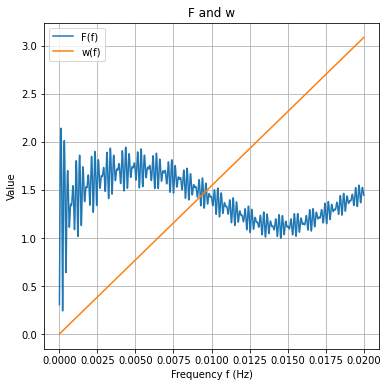

In [3]:
# F(f) vs f
v = 250 # km/s
z_L = 0.2
z_S = 1.0
y = 1

freq_vals = np.linspace(0.00001, 0.02, 2000)
MLz = M_Lz(v, z_L, z_S)
w_vals = w_f_sis(freq_vals, MLz, z_L)

amp_vals = np.array([F_f_sis(w, y) for w in w_vals])

plt.figure(figsize=(6, 6))
plt.plot(freq_vals, np.abs(amp_vals), label="F(f)")
plt.plot(freq_vals, w_vals, label="w(f)")
plt.grid(True)
plt.xlabel("Frequency f (Hz)")
plt.ylabel("Value")
plt.title("F and w")
plt.legend()
plt.savefig("images/F_w_sis.png", dpi=600)
plt.show()

In [4]:
# Equations for LISA-Measured Signals


# just to reduce L*n to cos(i) for now for full effect...
def L_vector(i):
    return np.array([np.sin(i), 0, np.cos(i)])
def n_vector():
    return np.array([0, 0, 1])

# chirp mass
def chirp_M(M1, M2):
    return (M1*M2)**(3/5) / (M1 + M2)**(1/5)

# redshifted chirp mass
def M_z(M1, M2, z_S):
    M1 = M1 * M_sun
    M2 = M2 * M_sun
    return chirp_M(M1, M2) * (1 + z_S)
    
# amplitude
def amplitude(z_S, M_z):
    D_S = cosmo.angular_diameter_distance(z_S).to('m').value
    return np.sqrt(5/96)*np.pi**(-2/3) * (G*M_z/c**3)**(5/6) / (D_S * (1+z_S)**2)

def psi_f(f, M_z, t_c, phi_c):
    return 2*np.pi*f*t_c - phi_c - np.pi/4 + 0.75*(8*np.pi*(G*M_z/c**3)*f)**(-5/3)

# unlensed h w/ plus polarization
def h_unlensed_plus(f, Mz, z_S, i, t_c=0, phi_c=0):
    A = amplitude(z_S, Mz)
    L_n = np.dot(L_vector(i), n_vector())
    psi = psi_f(f, Mz, t_c, phi_c)
    
    h_plus = A * (1+L_n**2)* f**(-7/6) * np.exp(1j*psi)
    
    return h_plus

# unlensed h w/ cross polarization
def h_unlensed_cross(f, Mz, z_S, i, t_c=0, phi_c=0):
    A = amplitude(z_S, Mz)
    L_n = np.dot(L_vector(i), n_vector())
    psi = psi_f(f, Mz, t_c, phi_c)
    
    h_cross = -2j * A * (L_n) * f**(-7/6) * np.exp(1j*psi)
    
    return h_cross

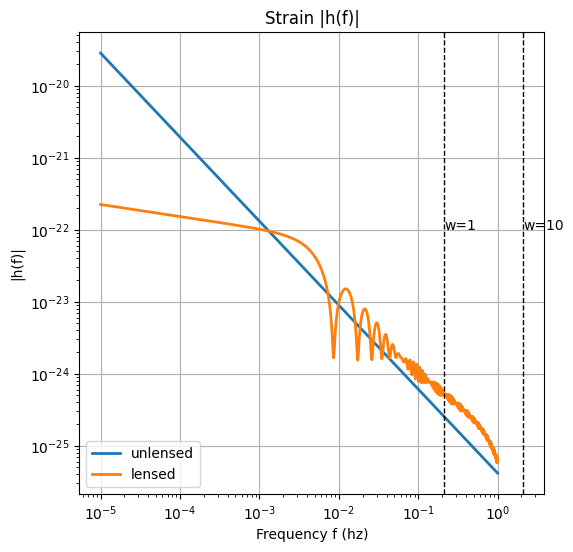

In [42]:
# LISA values

v = 100 # km/s
z_L = 0.2
z_S = 1.0
y = 0.5

f = np.linspace(0.00001, 1.0, 10000)

M1 = 1e7
M2 = 1e7
z_S = 1

Mz = M_z(M1, M2, z_S)
MLz = M_Lz(v, z_L, z_S)

def f_at_w(x, M_L, z_L):
    M_L = M_L * M_sun
    return x / (8*np.pi*(G*M_L*(1 + z_L)/c**4))
f_wave = f_at_w(1, MLz, z_L)
f_geom = f_at_w(10, MLz, z_L)


wf = w_f_sis(f, MLz, z_L)
Ff = np.array([F_f_sis(w, y) for w in wf])

h_plus = h_unlensed_plus(f, Mz, z_S, 0)
h_plus_lensed = h_plus * Ff

plt.figure(figsize=(6, 6))
plt.plot(f, np.abs(h_plus), linewidth=2, label="unlensed")
plt.plot(f, np.abs(h_plus_lensed), linewidth=2, label="lensed")

plt.axvline(x=f_wave, color='black', linestyle='--', linewidth=1)
plt.text(f_wave + 0.0005, 1e-22, "w=1")
plt.axvline(x=f_geom, color='black', linestyle='--', linewidth=1)
plt.text(f_geom + 0.0005, 1e-22, "w=10")

plt.xlabel("Frequency f (hz)")
plt.ylabel("|h(f)|")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.title("Strain |h(f)|")
plt.savefig("images/hf_sis.png", dpi=600)
plt.show()

In [6]:
from pycbc.waveform import get_fd_waveform

hp, hc = get_fd_waveform(
    approximant="IMRPhenomD",
    mass1=30, mass2=30,
    delta_f=1/2048,
    f_lower=20
)

hp_lensed = Ff * hp
hc_lensed = Ff * hc
plt.figure(figsize=(6, 6))
plt.plot(hp.sample_frequencies, np.abs(hp_lensed), linewidth=2, label="lensed (+)")
plt.plot(hc.sample_frequencies, np.abs(hc_lensed), linewidth=2, label="lensed (x)")

plt.xlabel("Frequency f (hz)")
plt.ylabel("|h(f)|")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.title("Strain |h(f)|")
#plt.savefig("images/hf_sis.png", dpi=600)
plt.show()

ValueError: operands could not be broadcast together with shapes (10000,) (2097153,) 

μ₊ =  3.0
μ- = 1.0
μ_geom = |μ₊| + |μ-| = 4.0


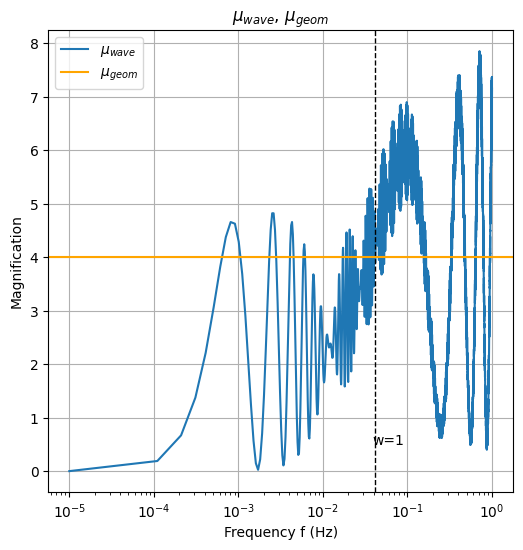

In [39]:
plt.figure(figsize=(6, 6))
plt.plot(f, np.abs(Ff)**2, label=r"$\mu_{wave}$")

mu_pos = 1 + 1/y
mu_neg = -1 + 1/y
mu_geom = np.abs(mu_pos) + np.abs(mu_neg)
print("μ₊ = ", mu_pos)
print("μ- =", mu_neg)
print("μ_geom = |μ₊| + |μ-| =", mu_geom)

plt.axvline(x=f_wave, color='black', linestyle='--', linewidth=1)
plt.text(f_wave - 0.0035, 0.5, "w=1")
plt.axhline(y=mu_geom, color="orange", label=r"$\mu_{geom}$")

plt.grid(True)
plt.xlabel("Frequency f (Hz)")
plt.ylabel("Magnification")
plt.xscale("log")
plt.title(r"$\mu_{wave}$, $\mu_{geom}$")
plt.legend()
plt.savefig("images/mu_sis.png", dpi=600)
plt.show()

In [7]:
def einstein_radius_SIS(v, z_L, z_S):
    v = (v * u.km/u.s).to(u.m/u.s).value
    
    # Angular diameter distances
    D_L = cosmo.angular_diameter_distance(z_L).to(u.m).value
    D_S = cosmo.angular_diameter_distance(z_S).to(u.m).value
    D_LS = cosmo.angular_diameter_distance_z1z2(z_L, z_S).to(u.m).value

    # Compute Einstein angular radius (radians)
    theta_E = 4 * np.pi * (v/c)**2 * (D_LS/D_S)

    return theta_E


In [8]:
# Time Delay Surface
def td(x1, x2, y1, y2, v, z_L, z_S, unit):
    
    D_L = cosmo.angular_diameter_distance(z_L).to(u.m).value
    D_S = cosmo.angular_diameter_distance(z_S).to(u.m).value
    D_LS = cosmo.angular_diameter_distance_z1z2(z_L, z_S).to(u.m).value
    theta_E = einstein_radius_SIS(v, z_L, z_S)
    
    xi_0 = D_L * theta_E
    
    psi_x = np.sqrt(x1**2 + x2**2) # SIS lens
    dist_sq = (x1 - y1)**2 + (x2 - y2)**2
    phys_const = (D_S * xi_0**2) / (D_L*D_LS) * (1 + z_L)
    
    if y1 >= 1:
        phi_m = 0.5
    else:
        phi_m = y1 + 0.5
        
    td_seconds = phys_const * (0.5 * dist_sq - psi_x) / c
    td_days = td_seconds / 60 / 60 / 24
    
    if unit == 'days':
        return td_days
    else:
        return td_seconds

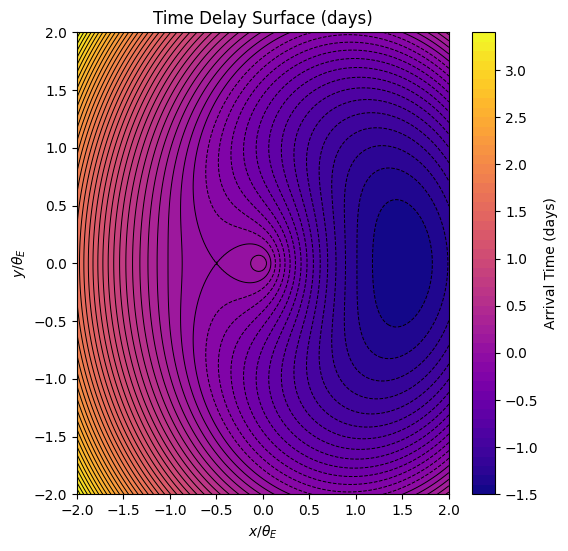

In [41]:
# Static TD surface
x1 = np.linspace(-2, 2, 200)
x2 = np.linspace(-2, 2, 200)
X1, X2 = np.meshgrid(x1, x2)

Y1 = 0.5
Y2 = 0.0

v = 100 # km/s

td_surface = td(X1, X2, Y1, Y2, v, z_L, z_S, 'days')
plt.figure(figsize=(6, 6))
plt.contourf(X1, X2, td_surface, levels=50, cmap="plasma")
plt.colorbar(label="Arrival Time (days)")
plt.contour(X1, X2, td_surface, 
        levels=50,        # number of lines
        colors='black',   # or 'black'
        linewidths=0.7)

plt.xlabel(r"$x / \theta_E$")
plt.ylabel(r"$y / \theta_E$")
plt.title("Time Delay Surface (days)")
plt.savefig("images/td_surface.png", dpi=600)
plt.show()

In [84]:
# Dynamic TD surface
x1 = np.linspace(-4, 4, 400)
x2 = np.linspace(-4, 4, 400)
X1, X2 = np.meshgrid(x1, x2)

v = 250  # km/s

def plot_td_dyn(y1, y2, show_min=False, show_sad=False):
    Y1, Y2 = y1, y2

    td_surface = td(X1, X2, Y1, Y2, v, z_L, z_S, 'days')

    plt.figure(figsize=(6, 6))
    plt.contourf(X1, X2, td_surface, levels=50, cmap="plasma")
    plt.colorbar(label="Arrival Time (days)")
    
    plt.contour(X1, X2, td_surface, 
            levels=50,        # number of lines
            colors='black',   # or 'black'
            linewidths=0.7)
    
    
    r = np.sqrt(Y1**2 + Y2**2)

    # Minimum image (always exists)
    x_min1 = Y1 + Y1/r
    x_min2 = Y2 + Y2/r
    T_min = td(x_min1, x_min2, Y1, Y2, v, z_L, z_S, 'days')

    # Highlight min
    if show_min:
        plt.scatter(x_min1, x_min2, color='white', s=60, edgecolor='black')
        plt.contour(X1, X2, td_surface, levels=[T_min], colors='white')
    
    if r < 1 and show_sad:
        x_sad1 = Y1 - Y1/r
        x_sad2 = Y2 - Y2/r
        T_sad = td(x_sad1, x_sad2, Y1, Y2, v, z_L, z_S, 'days')
        print(T_min, T_sad)

        plt.scatter(x_sad1, x_sad2, color='white', s=60, edgecolor='black')
        plt.contour(X1, X2, td_surface, levels=[T_sad], colors='red')
    else:
        x_sad1 = None
        x_sad2 = None
    plt.xlabel(r"$x_1 / \theta_E$")
    plt.ylabel(r"$x_2 / \theta_E$")
    plt.title(f"Time Delay Surface  (y₁={y1:.2f}, y₂={y2:.2f})")
    #plt.savefig("images/td_surface2.png", dpi=600)
    plt.show()



interact(plot_td_dyn, 
         y1=FloatSlider(min=0.00001, max=2, step=0.02, value=1.0, description=r"$y_1 / \theta_E$"), 
         y2=FloatSlider(min=0, max=2, step=0.02, value=0.0, description=r"$y_2 / \theta_E$"), 
         show_min=widgets.Checkbox(value=False, description=r'$minimum$'), 
         show_sad=widgets.Checkbox(value=False, description=r'$saddle$'));

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


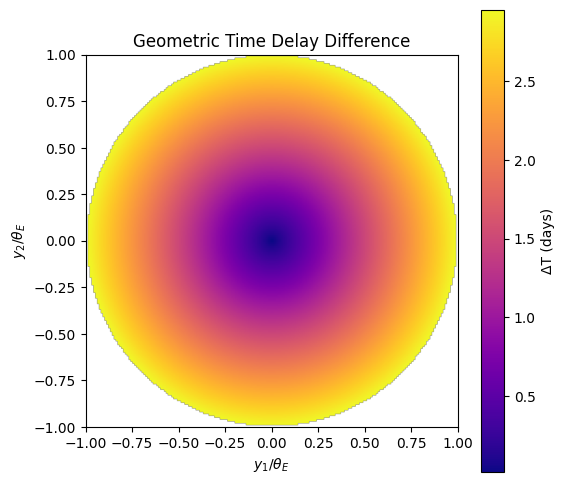

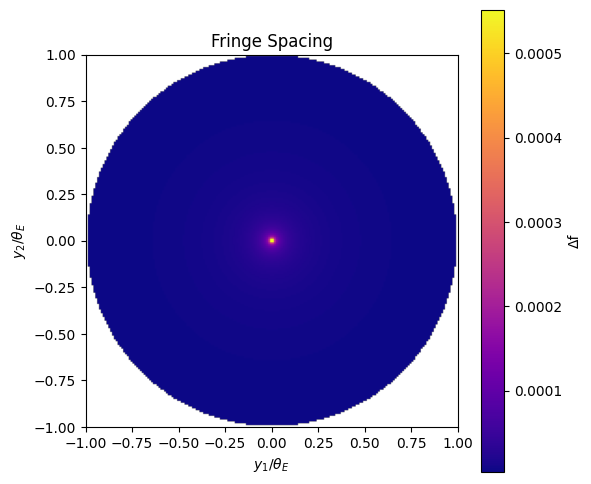

In [40]:
v = 100  # km/s

def td_sis(y1, y2):
    Y1, Y2 = y1, y2
    
    r = np.sqrt(Y1**2 + Y2**2)

    # Minimum image (always exists)
    if r == 0:
        # Einstein ring
        x_out1 = 1.0
        x_out2 = 0.0
        T_outer = td(x_out1, x_out2, Y1, Y2, v, z_L, z_S, 'days')

        # opposite point on ring
        x_in1 = -1.0
        x_in2 = 0.0
        T_inner = td(x_in1, x_in2, Y1, Y2, v, z_L, z_S, 'days')

    else:
        alpha_out = 1 + 1/r
        x_out1 = alpha_out * Y1
        x_out2 = alpha_out * Y2
        T_outer = td(x_out1, x_out2, Y1, Y2, v, z_L, z_S, 'days')

        # -------- inner minimum only if r < 1 --------
        if r < 1:
            alpha_in = 1 - 1/r
            x_in1 = alpha_in * Y1
            x_in2 = alpha_in * Y2
            T_inner = td(x_in1, x_in2, Y1, Y2, v, z_L, z_S, 'days')
        else:
            T_inner = None

    return T_outer, T_inner

y1 = np.linspace(-1, 1, 200)
y2 = np.linspace(-1, 1, 200)
Y1, Y2 = np.meshgrid(y1, y2)

DeltaT = np.full_like(Y1, np.nan)
FringeSpacing = np.full_like(Y1, np.nan)

for i in range(Y1.shape[0]):
    for j in range(Y1.shape[1]):
        y1_val = Y1[i, j]
        y2_val = Y2[i, j]

        T_outer, T_inner = td_sis(y1_val, y2_val)

        if T_inner is not None:
            DeltaT_val = T_inner - T_outer

            # avoid division by zero
            if np.abs(DeltaT_val) < 1e-12:
                DeltaT[i, j] = np.nan
                FringeSpacing[i, j] = np.nan
            else:
                DeltaT[i, j] = DeltaT_val
                FringeSpacing[i, j] = 1.0 / (DeltaT_val * 86400)

plt.figure(figsize=(6,6))
plt.imshow(DeltaT, origin='lower', extent=[-1,1,-1,1], cmap='plasma')
plt.colorbar(label='ΔT (days)')
plt.xlabel(r"$y_1 / \theta_E$")
plt.ylabel(r"$y_2 / \theta_E$")
plt.title('Geometric Time Delay Difference')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(FringeSpacing, origin='lower', extent=[-1,1,-1,1], cmap='plasma')
plt.colorbar(label='Δf')
plt.xlabel(r"$y_1 / \theta_E$")
plt.ylabel(r"$y_2 / \theta_E$")
plt.title('Fringe Spacing')
plt.show()